# Multilabel classification with BERT
1. Goal
  - Build a model that predicts tags (keywords) of articles published on arxiv.
  - Compare different solutions for class imbalance problem and multilabel classification problem. Specifically: 
    - Sampling methods: LPROS vs. MLROS. 
    - Multilabel classification: binary relevance vs. classifier chain vs. KNN vs. deep learning

2. Data: Abstracts published in academic journals https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts?select=arxiv_data.csv

3. Class Imbalance
  - The dataset is imbalanced when the occurrence of each label is not equal. In this project, I used the label powerset random oversampling and multilabel random oversampling methods. The LPROS and MLROS approaches are chosen because two methods outperformed other techniques in a recent article ([Terekegn et al., 2021](https://www.sciencedirect.com/science/article/pii/S0031320321001527))

4. BERT
  - Bidirectional Encoder Representations from Transformers (BERT) is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google ([Devlin et al., 2018](https://arxiv.org/abs/1810.04805)). A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data.

5. Binary Relevance vs. Classifier Chain
  - Binary relevance approach works by building an independent binary classifier for each class. 
  - Classifier chain approach works by buidling a binary classifier for each class. The classifier for class i uses predictions from classifier class j where i > j. 

6. MLKNN
  - ML-KNN is derived from the traditional K-nearest neighbor (KNN) algorithm. For each unseen instance, its K nearest neighbors in the training set are firstly identified. After that, based on information gained from the label sets of these neighboring instances, maximum a posteriori (MAP) principle is utilized to determine the label set for the unseen instance ([Zhang & Zhou, 2007](https://www.sciencedirect.com/science/article/pii/S0031320307000027)).

## Setup

In [2]:
# To run KNN, 0.24.1 is required 
import sklearn
sklearn.__version__

'0.24.1'

In [3]:
# Import packages
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from skmultilearn.problem_transform import ClassifierChain
import warnings
warnings.filterwarnings('ignore')
import scipy.sparse
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, hamming_loss
import joblib

In [4]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval
import matplotlib.pyplot as plt

## Import Data

### Kaggle

In [ ]:
# Import data
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d spsayakpaul/arxiv-paper-abstracts

In [ ]:
!unzip arxiv-paper-abstracts.zip -d kaggle

In [12]:
df = pd.read_csv("/content/kaggle/arxiv_data.csv")

In [13]:
print(df.shape)
df.head()

(51774, 3)


,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [14]:
total_duplicate_titles = sum(df["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [15]:
df = df[~df["titles"].duplicated()]
print(f"There are {len(df)} rows in the clean dataset.")
# Select samples
df = df.sample(n = 5000, random_state = 1)
# Choose the column 
df = df[["summaries", "terms"]]

There are 38972 rows in the clean dataset.


## Binary Relevance, Classifier Chain, MLKNN 
### Preprocessing

#### Filtering

In [16]:
# Convert list of strings to lists 
df['terms'] = df['terms'].apply(lambda x: ast.literal_eval(x))

In [17]:
# Calculate the number of unique keywords in "Terms" column
print(df['terms'].explode().value_counts()[0:10])
print("Number of unique terms:", len(df['terms'].explode().unique()))

cs.CV      2854
cs.LG      2826
stat.ML    1573
cs.AI       729
eess.IV     214
cs.RO       208
cs.CL       138
cs.NE       136
cs.CR        77
math.OC      77
Name: terms, dtype: int64
Number of unique terms: 273


In [18]:
# Choose top 5 keywords 
from collections import Counter
top_terms_list = Counter(list(df['terms'].explode())).most_common(5)
top_terms = [a_tuple[0] for a_tuple in top_terms_list]
top_terms

['cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV']

In [19]:
df['terms'].head()

1342                                               [cs.CV]
19326                                       [cs.CV, cs.AI]
22098    [cs.LG, physics.app-ph, physics.chem-ph, physi...
48541                                [cs.LG, cs.AI, cs.SE]
12544                                       [cs.CV, cs.LG]
Name: terms, dtype: object

In [20]:
df.reset_index(drop=True, inplace=True)

In [21]:
# Filter out records that have at least one of the top keywords
x = [] # To store the filtered text (features)
y = [] # to store the corresponding terms (labels)

for i in range(len(df['terms'])):
    temp = []
    for term in df['terms'][i]:
        if term in top_terms:
            temp.append(term)

    if(len(temp)>0):
        x.append(df['summaries'][i])
        y.append(temp)

#### One Hot Encoding: Individual Labels

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer() 
yt = mlb.fit_transform(y)
yt.shape

(5000, 5)

In [23]:
yt

array([[0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0]])

In [24]:
# build a dataframe with the feature (text) and labels 
df_filtered = pd.DataFrame()
df_filtered['text'] = x
df_labels = pd.DataFrame(yt, columns = top_terms)
df_filtered = pd.concat([df_filtered, df_labels], axis = 1)

#### Label Powerset 

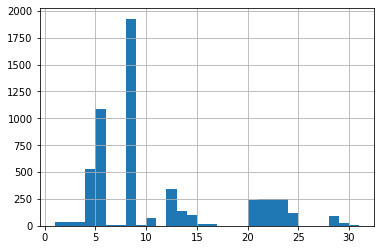

In [25]:
# Add label powerset 
df_filtered['powerlabel'] = df_filtered.apply(lambda x : 16*x['cs.CV']+8*x['cs.LG']+4*x['stat.ML']+2*x['cs.AI']+1*x['eess.IV'],axis=1)

# Create a histogram to confirm data imbalance 
df_filtered['powerlabel'].hist(bins=np.unique(df_filtered['powerlabel']))

In [26]:
df_filtered.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,"This report describes the design, implementati...",0,1,0,0,0,8
1,Recent advances in document image analysis (DI...,1,1,0,0,0,24
2,Bayesian optimization (BO) is a popular paradi...,0,0,1,0,0,4
3,Learning algorithms produce software models fo...,1,0,1,0,0,20
4,Capsules are the name given by Geoffrey Hinton...,0,1,1,0,0,12


#### Train-test split

In [27]:
train, test = train_test_split(df_filtered, test_size = 0.3, random_state = 1)
train = train.reset_index(drop = True)

In [28]:
train.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,Today deep convolutional neural networks (CNNs...,0,1,0,0,0,8
1,"In the paper, we propose a class of efficient ...",0,0,1,0,1,5
2,The generative adversarial network (GAN) exhib...,0,1,1,1,0,14
3,Though convolutional neural networks are widel...,1,1,0,0,0,24
4,"In recent years, advances in the development o...",0,1,0,0,0,8


#### LP-ROS (Label Powerset Random Oversampling)
- The Label Powerset transformation method transforms the multilabel data into a multi-class dataset, processing each different combination of labels (label-set) as a class. In other words, label powerset approach converts a multilabel classification problem into a multiclass classification problem. 
- LP-ROS (Label Powerset Random Over Sampling) is a multi-label random oversampling method that works by cloning random samples of minority label-sets until the size of the multilabel data increases by the prespecified percentage.  
- In this notebook, we set the number of minority labels to equal to the number of the majority label. 
- Reference: [Imbalanced Multilabel Scene Classification using Keras](https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b) 

In [29]:
train_lpros = train.copy()

In [30]:
powercount = {}
powerlabels = np.unique(train['powerlabel'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(train['powerlabel'] == p)

maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    #print(gapnum)
    temp_df = train.iloc[np.random.choice(np.where(train['powerlabel'] == p)[0], size = gapnum)]
    train_lpros = train_lpros.append(temp_df, ignore_index=True)
    
#train_lpros = train.sample(frac = 1).reset_index(drop=True)

In [31]:
train_lpros.shape

(29414, 7)

In [32]:
powercount_lpros = {}
powerlabels = np.unique(train['powerlabel'])
for p in powerlabels:
    powercount_lpros[p] = np.count_nonzero(train_lpros['powerlabel'] == p)
powercount_lpros

{1: 1337,
 4: 1337,
 5: 1337,
 6: 1337,
 7: 1337,
 8: 1337,
 9: 1337,
 10: 1337,
 11: 1337,
 12: 1337,
 13: 1337,
 14: 1337,
 15: 1337,
 17: 1337,
 20: 1337,
 21: 1337,
 24: 1337,
 25: 1337,
 28: 1337,
 29: 1337,
 30: 1337,
 31: 1337}

#### ML-ROS (Multilabel Random Oversampling)

- ML-ROS is an approach based on the frequency of individual labels, instead of the full label-sets. 
- ML-ROS relies on IRLbl (imbalance ratio per label) and MeanIR (mean imbalance ratio) measures. Labels whose IRLbl is greater than MeanIR are considered to be minority labels, while labels whose IRLbl is smaller than MeanIR can be considered to be majority labels.
- In the current notebook, we use the ML-ROS technique that uses IRLbl and MeanIR to identify majority and minority labels ([Charte, 2018](https://arxiv.org/pdf/1802.05031.pdf)). 

In [33]:
# calculate Mean IR and IRLbl
def IRLbl(labels):
  """Takes a 2d array of labels and returns a list of the imbalance ratio per label. 
  imbalance ratio per label: (the number of instances of majority label) / (the number of instances of a specific label)

  Input:
    labels: a 2d numpy array. Each row is one instance, each column is one class; the array contains (0, 1) only

  Returns:
    irlbl: imbalance ratio for each label 
  """
  N, C = labels.shape
  pos_nums_per_label = np.sum(labels, axis = 0)
  max_pos_nums = np.max(pos_nums_per_label)
  return max_pos_nums / pos_nums_per_label

def MeanIR(labels):
  """Takes a 2d array of labels and returns the mean of imbalance ratios. 
  Input:
    labels: a 2d numpy array. Each row is one instance, each column is one class; the array contains (0, 1) only

  Returns: 
    mean of imbalance ratios: integer 
  """
  IRLbl_VALUE = IRLbl(labels)
  return np.mean(IRLbl_VALUE)

In [34]:
import random

def ML_ROS(df, labels, max_clone_percentage=50):
  """
  Algorithm: https://arxiv.org/pdf/1802.05031.pdf
  Reference: https://github.com/Bupenieks/ImbalancedMLC/blob/master/dataset_metrics.ipynb  
  """
  # N of samples to clone, obtain the set of labels
  labels_df = df[labels]
  N, C = labels_df.shape
  num_samples_to_clone = N / 100 * max_clone_percentage
  print('Number of samples to clone:', num_samples_to_clone)

  # for each label, add samples to the minority bag if the IRLbl < MeanIR
  minority_classes = []
  MeanIR_value = MeanIR(labels_df)
  IRLbl_value = IRLbl(labels_df)

  df_idx = df.index
  map = {}
  for l in labels:
    l_indices = df_idx[df[l] == 1].tolist()
    map[l] = l_indices
    min_bags = {l:ins for l, ins in map.items() if IRLbl_value[l] > MeanIR_value}
  print('Minority label:', min_bags.keys())

  # Clone a random sample from each minority bag
  new_df = df
  while num_samples_to_clone > 0:
    for l in min_bags:
      instance_to_clone = random.choice(min_bags[l])
      new_df = new_df.append(df.iloc[instance_to_clone])
      new_IRs = IRLbl(new_df[labels])
      new_IR_l = new_IRs[l]

    if new_IR_l <= MeanIR_value:
      # Exclude from cloning
      del min_bags[l]
                        
    num_samples_to_clone -= 1

    if len(min_bags.keys()) == 0:
      print("Unable to clone all samples. {} left to clone".format(num_samples_to_clone))
      break

  return new_df

In [35]:
labels = ['cs.CV',	'cs.LG',	'stat.ML',	'cs.AI',	'eess.IV']
train_mlros = ML_ROS(train, labels)

Number of samples to clone: 1750.0
Minority label: dict_keys(['cs.AI'])
Unable to clone all samples. 1322.0 left to clone


In [36]:
train_mlros.shape

(3928, 7)

In [37]:
print(MeanIR(train[labels]))
IRLbl(train[labels])

4.139988862143587


cs.CV       3.875486
cs.LG       1.000000
stat.ML     1.000502
cs.AI      13.019608
eess.IV     1.804348
dtype: float64

In [38]:
print(MeanIR(train_mlros[labels]))
IRLbl(train_mlros[labels])

2.574434639427914


cs.CV      4.570342
cs.LG      1.000000
stat.ML    1.060900
cs.AI      4.137694
eess.IV    2.103237
dtype: float64

In [39]:
train_lpros.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,Today deep convolutional neural networks (CNNs...,0,1,0,0,0,8
1,"In the paper, we propose a class of efficient ...",0,0,1,0,1,5
2,The generative adversarial network (GAN) exhib...,0,1,1,1,0,14
3,Though convolutional neural networks are widel...,1,1,0,0,0,24
4,"In recent years, advances in the development o...",0,1,0,0,0,8


In [40]:
train_mlros.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,Today deep convolutional neural networks (CNNs...,0,1,0,0,0,8
1,"In the paper, we propose a class of efficient ...",0,0,1,0,1,5
2,The generative adversarial network (GAN) exhib...,0,1,1,1,0,14
3,Though convolutional neural networks are widel...,1,1,0,0,0,24
4,"In recent years, advances in the development o...",0,1,0,0,0,8


#### Embeddings: BERT

In [41]:
# Generate embeddings
model = SentenceTransformer('multi-qa-distilbert-dot-v1')
def bert_embeddings(col):
  sentences = list(col)
  sentence_embeddings = model.encode(sentences)
  sentence_embeddings_df = pd.DataFrame(sentence_embeddings)
  return sentence_embeddings_df

In [42]:
X_train_mlros = bert_embeddings(train_mlros['text'])
y_train_mlros = train_mlros[labels]

In [43]:
X_train_lpros = bert_embeddings(train_lpros['text'])
y_train_lpros = train_lpros[labels]

In [44]:
X_train = bert_embeddings(train['text'])
y_train = train[labels]

In [45]:
X_test = bert_embeddings(test['text'])
y_test = test[labels]

### Model
- Binary Relevance
- Classifier Chain
- [Multilabel K-Nearest Neighbors](http://scikit.ml/api/skmultilearn.adapt.mlknn.html): "uses k-NearestNeighbors find nearest examples to a test class and uses Bayesian inference to select assigned labels."



### Classifier Chain

In [46]:
def cc_lr_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = ClassifierChain(LogisticRegression())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

In [47]:
# using classifier chain + naive bayes
def cc_nb_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = ClassifierChain(GaussianNB())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

### Binary Relevance

In [48]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

def br_nb_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = BinaryRelevance(GaussianNB())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

In [49]:
# using binary relevance + logistic regression
def br_lr_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = BinaryRelevance(LogisticRegression())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

### KNN

In [57]:
# KNN


from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

def mlknn_fit(X_train, y_train, X_test, k, score):
  """
  Returns:
    classifier: a fitted KNN classifier
    y_pred: predictions 

  Error:
    for "TypeError: __init__() takes 1 positional argument but 2 were given", install the old version of sklearn
    !pip uninstall scikit-learn -y
    !pip install scikit-learn==0.24.1
  """
  # initialize classifier chains multi-label classifier
  classifier = MLkNN(k)

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

### Fitting

In [51]:
cc_lr_raw, y_pred_cc_lr_raw = cc_lr_fit(X_train, y_train, X_test)
cc_nb_raw, y_pred_cc_nb_raw = cc_nb_fit(X_train, y_train, X_test)
br_lr_raw, y_pred_br_lr_raw = br_lr_fit(X_train, y_train, X_test)
br_nb_raw, y_pred_br_nb_raw = br_nb_fit(X_train, y_train, X_test)

In [52]:
cc_lr_mlros, y_pred_cc_lr_mlros = cc_lr_fit(X_train_mlros, y_train_mlros, X_test)
cc_nb_mlros, y_pred_cc_nb_mlros = cc_nb_fit(X_train_mlros, y_train_mlros, X_test)
br_lr_mlros, y_pred_br_lr_mlros = br_lr_fit(X_train_mlros, y_train_mlros, X_test)
br_nb_mlros, y_pred_br_nb_mlros = br_nb_fit(X_train_mlros, y_train_mlros, X_test)

In [53]:
cc_lr_lpros, y_pred_cc_lr_lpros = cc_lr_fit(X_train_lpros, y_train_lpros, X_test)
cc_nb_lpros, y_pred_cc_nb_lpros = cc_nb_fit(X_train_lpros, y_train_lpros, X_test)
br_lr_lpros, y_pred_br_lr_lpros = br_lr_fit(X_train_lpros, y_train_lpros, X_test)
br_nb_lpros, y_pred_br_nb_lpros = br_nb_fit(X_train_lpros, y_train_lpros, X_test)

In [54]:
# To use the mlknn package, the dataset should be converted to a sparse matrix.
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)
y_train_sparse = scipy.sparse.csr_matrix(y_train.values)
X_train_mlros_sparse = scipy.sparse.csr_matrix(X_train_mlros.values)
y_train_mlros_sparse = scipy.sparse.csr_matrix(y_train_mlros.values)
X_train_lpros_sparse = scipy.sparse.csr_matrix(X_train_lpros.values)
y_train_lpros_sparse = scipy.sparse.csr_matrix(y_train_lpros.values)

In [59]:
score = 'f1_macro'
k = 5
mlknn_raw, y_pred_mlknn_raw = mlknn_fit(X_train_sparse, y_train_sparse, X_test, k, score)
mlknn_mlros, y_pred_mlknn_mlros = mlknn_fit(X_train_mlros_sparse, y_train_mlros_sparse, X_test, k, score)
mlknn_lpros, y_pred_mlknn_lpros = mlknn_fit(X_train_lpros_sparse, y_train_lpros_sparse, X_test, k, score)

## Compare Results 
- Evaluation metrics for classification problem
  - Accuracy: number of correct predictions / total predictions. The accuracy could be misleading when the dataset is not balanced. For example, if there are four positives and one negative, the model that predicts all samples to be positive achieves 80% accuracy. 
  - Precision: true positives divided by the number of samples that were predicted to be positive. TP / (TP + FP)
  - Recall: true positives divided by true positives + false negatives. TP / (TP + FN)
  - The F1 score is the harmonic mean of the precision and recall. 2*(precision *  recall) / (precision + recall). 
  - Macro average: simple average of all classes. For example, if there are three classes, the macro average for precision is the average of precision of class A, precision of class B, and precision of class C.  
  - Micro average: this is calculated by considering all true positives, false positives, and false negatives. For example, the micro average for precision is: sum of true positives (across three classes) / sum of true positives + sum of false positives 
  - Weighted average: average of the metric values weighted by the support of that class. For example: Precision of class A * Support of class A + Precision of class B * Support of class B / (Support of class A + Support of class B) 
  - [Hamming Loss](https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd): computes the proportion of incorrectly predicted labels to the total number of labels. For a multilabel classification, we compute the number of False Positives and False Negative per instance and then average it over the total number of training instances. $\frac{1}{|N|*|L|}\sum_{i=1}^N \sum_{j=1}^L xor(y_{i,j}, z_{i,j})$. Where N is the number of samples, L is the number of classes, $y_{ij}$ is the true label, $z_{ij}$ is the predicted label, and xor is the operator that returns zero if the prediction and the true label are the same. The optimal value for the hamming loss is zero.   



In [60]:
def results(y_test, y_pred, labels, X_train, X_test):
  print(classification_report(y_test, y_pred, target_names=labels))
  print("Training Dataset Count", X_train.shape[0])
  print("Test Dataset Count", X_test.shape[0])
  print("Weighted Precision", precision_score(y_test, y_pred, average='weighted'))
  print("Weighted Recall", recall_score(y_test, y_pred, average='weighted'))
  print("Weighted F1", f1_score(y_test, y_pred, average='weighted'))
  print("Accuracy", accuracy_score(y_test, y_pred))
  print("Hamming Loss", hamming_loss(y_test, y_pred))

#### Raw data

In [61]:
# Classification report for raw data (imbalanced data) 
results(y_test, y_pred_cc_lr_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.33      0.16      0.21       215
       cs.LG       0.89      0.90      0.89       862
     stat.ML       0.85      0.81      0.83       835
       cs.AI       0.09      0.05      0.06        61
     eess.IV       0.61      0.62      0.62       469

   micro avg       0.78      0.73      0.75      2442
   macro avg       0.55      0.51      0.52      2442
weighted avg       0.75      0.73      0.74      2442
 samples avg       0.83      0.80      0.78      2442

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7542915005405129
Weighted Recall 0.7289107289107289
Weighted F1 0.7385891999574948
Accuracy 0.4806666666666667
Hamming Loss 0.15453333333333333


In [62]:
results(y_test, y_pred_cc_nb_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.48      0.39       215
       cs.LG       0.90      0.89      0.90       862
     stat.ML       0.91      0.79      0.84       835
       cs.AI       0.07      0.49      0.13        61
     eess.IV       0.59      0.80      0.68       469

   micro avg       0.66      0.79      0.72      2442
   macro avg       0.56      0.69      0.59      2442
weighted avg       0.77      0.79      0.77      2442
 samples avg       0.69      0.84      0.72      2442

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7734314692280188
Weighted Recall 0.7927927927927928
Weighted F1 0.7733896587372856
Accuracy 0.31066666666666665
Hamming Loss 0.2024


In [63]:
results(y_test, y_pred_br_lr_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.33      0.16      0.21       215
       cs.LG       0.89      0.90      0.90       862
     stat.ML       0.84      0.84      0.84       835
       cs.AI       0.03      0.02      0.02        61
     eess.IV       0.62      0.58      0.59       469

   micro avg       0.78      0.73      0.75      2442
   macro avg       0.54      0.50      0.51      2442
weighted avg       0.75      0.73      0.74      2442
 samples avg       0.82      0.80      0.77      2442

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7484836382551212
Weighted Recall 0.730958230958231
Weighted F1 0.7368768895657534
Accuracy 0.4553333333333333
Hamming Loss 0.15506666666666666


In [64]:
results(y_test, y_pred_br_nb_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.48      0.39       215
       cs.LG       0.91      0.90      0.90       862
     stat.ML       0.90      0.81      0.85       835
       cs.AI       0.07      0.46      0.13        61
     eess.IV       0.61      0.80      0.70       469

   micro avg       0.67      0.80      0.73      2442
   macro avg       0.56      0.69      0.59      2442
weighted avg       0.78      0.80      0.78      2442
 samples avg       0.71      0.85      0.74      2442

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7759783676204339
Weighted Recall 0.800982800982801
Weighted F1 0.7802777062670232
Accuracy 0.33
Hamming Loss 0.1928


In [65]:
results(y_test, y_pred_mlknn_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.42      0.27      0.33       215
       cs.LG       0.87      0.92      0.90       862
     stat.ML       0.86      0.81      0.84       835
       cs.AI       0.40      0.03      0.06        61
     eess.IV       0.65      0.53      0.58       469

   micro avg       0.80      0.73      0.76      2442
   macro avg       0.64      0.51      0.54      2442
weighted avg       0.77      0.73      0.74      2442
 samples avg       0.84      0.80      0.79      2442

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7737869984320097
Weighted Recall 0.7293202293202293
Weighted F1 0.744596570015297
Accuracy 0.49666666666666665
Hamming Loss 0.1472


#### MLROS

In [66]:
results(y_test, y_pred_cc_lr_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.16      0.22       215
       cs.LG       0.88      0.91      0.90       862
     stat.ML       0.83      0.81      0.82       835
       cs.AI       0.07      0.10      0.08        61
     eess.IV       0.61      0.59      0.60       469

   micro avg       0.76      0.73      0.74      2442
   macro avg       0.54      0.51      0.52      2442
weighted avg       0.74      0.73      0.73      2442
 samples avg       0.81      0.80      0.77      2442

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7434889262727635
Weighted Recall 0.7289107289107289
Weighted F1 0.7336679690523359
Accuracy 0.45666666666666667
Hamming Loss 0.16386666666666666


In [67]:
results(y_test, y_pred_cc_nb_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.50      0.39       215
       cs.LG       0.90      0.89      0.90       862
     stat.ML       0.90      0.81      0.85       835
       cs.AI       0.07      0.52      0.13        61
     eess.IV       0.59      0.81      0.68       469

   micro avg       0.65      0.80      0.72      2442
   macro avg       0.56      0.71      0.59      2442
weighted avg       0.77      0.80      0.78      2442
 samples avg       0.69      0.85      0.73      2442

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7689531116042975
Weighted Recall 0.8046683046683046
Weighted F1 0.7765447188089878
Accuracy 0.30666666666666664
Hamming Loss 0.2044


In [68]:
results(y_test, y_pred_br_lr_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.16      0.22       215
       cs.LG       0.88      0.91      0.89       862
     stat.ML       0.82      0.84      0.83       835
       cs.AI       0.09      0.11      0.10        61
     eess.IV       0.61      0.56      0.59       469

   micro avg       0.76      0.73      0.75      2442
   macro avg       0.55      0.52      0.53      2442
weighted avg       0.74      0.73      0.73      2442
 samples avg       0.81      0.80      0.77      2442

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7414861992856538
Weighted Recall 0.7334152334152334
Weighted F1 0.7347231144331895
Accuracy 0.436
Hamming Loss 0.16253333333333334


In [69]:
results(y_test, y_pred_br_nb_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.50      0.39       215
       cs.LG       0.90      0.89      0.90       862
     stat.ML       0.89      0.83      0.86       835
       cs.AI       0.07      0.48      0.13        61
     eess.IV       0.61      0.81      0.69       469

   micro avg       0.66      0.81      0.73      2442
   macro avg       0.56      0.70      0.59      2442
weighted avg       0.77      0.81      0.78      2442
 samples avg       0.70      0.85      0.73      2442

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7689804385625978
Weighted Recall 0.8087633087633087
Weighted F1 0.7802324974953598
Accuracy 0.31733333333333336
Hamming Loss 0.1972


In [70]:
results(y_test, y_pred_mlknn_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.42      0.27      0.33       215
       cs.LG       0.86      0.90      0.88       862
     stat.ML       0.80      0.81      0.81       835
       cs.AI       0.06      0.07      0.06        61
     eess.IV       0.64      0.51      0.57       469

   micro avg       0.75      0.72      0.74      2442
   macro avg       0.56      0.51      0.53      2442
weighted avg       0.74      0.72      0.73      2442
 samples avg       0.81      0.78      0.76      2442

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.740256144500976
Weighted Recall 0.7211302211302212
Weighted F1 0.7277281648046727
Accuracy 0.45
Hamming Loss 0.16706666666666667


#### LPROS

In [72]:
results(y_test, y_pred_cc_lr_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.20      0.34      0.25       215
       cs.LG       0.85      0.89      0.87       862
     stat.ML       0.73      0.85      0.78       835
       cs.AI       0.07      0.15      0.09        61
     eess.IV       0.54      0.53      0.53       469

   micro avg       0.64      0.74      0.69      2442
   macro avg       0.48      0.55      0.51      2442
weighted avg       0.67      0.74      0.70      2442
 samples avg       0.69      0.80      0.69      2442

Training Dataset Count 29414
Test Dataset Count 1500
Weighted Precision 0.6704410997894021
Weighted Recall 0.7416052416052417
Weighted F1 0.7022379011511257
Accuracy 0.2846666666666667
Hamming Loss 0.222


In [73]:
results(y_test, y_pred_cc_nb_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.23      0.50      0.31       215
       cs.LG       0.80      0.90      0.85       862
     stat.ML       0.59      0.95      0.73       835
       cs.AI       0.03      0.03      0.03        61
     eess.IV       0.56      0.30      0.40       469

   micro avg       0.59      0.75      0.66      2442
   macro avg       0.44      0.54      0.46      2442
weighted avg       0.61      0.75      0.65      2442
 samples avg       0.63      0.80      0.66      2442

Training Dataset Count 29414
Test Dataset Count 1500
Weighted Precision 0.6146828165760954
Weighted Recall 0.7452907452907452
Weighted F1 0.652862025088922
Accuracy 0.14666666666666667
Hamming Loss 0.25453333333333333


In [74]:
results(y_test, y_pred_br_lr_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.20      0.34      0.25       215
       cs.LG       0.85      0.89      0.87       862
     stat.ML       0.73      0.87      0.80       835
       cs.AI       0.08      0.20      0.12        61
     eess.IV       0.54      0.53      0.53       469

   micro avg       0.64      0.75      0.69      2442
   macro avg       0.48      0.57      0.51      2442
weighted avg       0.67      0.75      0.71      2442
 samples avg       0.69      0.80      0.69      2442

Training Dataset Count 29414
Test Dataset Count 1500
Weighted Precision 0.673032126632292
Weighted Recall 0.7477477477477478
Weighted F1 0.7061137954974611
Accuracy 0.2693333333333333
Hamming Loss 0.22106666666666666


In [75]:
results(y_test, y_pred_br_nb_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.23      0.50      0.31       215
       cs.LG       0.80      0.90      0.85       862
     stat.ML       0.59      0.95      0.73       835
       cs.AI       0.01      0.02      0.02        61
     eess.IV       0.57      0.30      0.40       469

   micro avg       0.58      0.74      0.66      2442
   macro avg       0.44      0.53      0.46      2442
weighted avg       0.61      0.74      0.65      2442
 samples avg       0.62      0.80      0.65      2442

Training Dataset Count 29414
Test Dataset Count 1500
Weighted Precision 0.6131598303652921
Weighted Recall 0.7448812448812449
Weighted F1 0.6514233094167725
Accuracy 0.142
Hamming Loss 0.2554666666666667


In [76]:
results(y_test, y_pred_mlknn_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.31      0.32      0.31       215
       cs.LG       0.86      0.81      0.84       862
     stat.ML       0.76      0.81      0.79       835
       cs.AI       0.06      0.07      0.06        61
     eess.IV       0.51      0.54      0.52       469

   micro avg       0.68      0.70      0.69      2442
   macro avg       0.50      0.51      0.50      2442
weighted avg       0.69      0.70      0.69      2442
 samples avg       0.73      0.75      0.70      2442

Training Dataset Count 29414
Test Dataset Count 1500
Weighted Precision 0.6894622981728942
Weighted Recall 0.6994266994266994
Weighted F1 0.6937668986247858
Accuracy 0.36
Hamming Loss 0.2032


## Conclusion
In terms of hamming loss, the mlknn algorithm combined with the raw data performs the best. However, it can't predict a minor label (cs.AI) at all. The classifier chain of logistic regressions can be an alternative.

## Appendix: Deep Learning
* Use deep learning to improve the accuracy of the model.
* Resource: https://keras.io/examples/nlp/multi_label_classification/

In [77]:
# remove entries of which term occurs once 
df['terms_tuple'] = df['terms'].map(tuple)
df_filtered_2 = df.groupby("terms_tuple").filter(lambda x: len(x) > 1)
df_filtered_2.shape

(4475, 3)

In [92]:
df_filtered_2["terms"] = df_filtered_2["terms"].apply(lambda x: literal_eval(str(x)))
df_filtered_2["terms"].values[:5]

array([list(['cs.CV']), list(['cs.CV', 'cs.AI']),
       list(['cs.CV', 'cs.LG']), list(['stat.ML', 'cs.LG']),
       list(['cs.LG'])], dtype=object)

In [93]:
# Initial train and test split.
train_2, test_2 = train_test_split(df_filtered_2, test_size=0.3, stratify=df_filtered_2["terms"].values, random_state=1)

# Splitting the test set further into validation
val_2 = test_2.sample(frac=0.5, random_state = 1)
test_2.drop(val_2.index, inplace=True)

In [94]:
train_2["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    3132.000000
mean      156.329183
std        41.462784
min        24.000000
25%       127.000000
50%       154.000000
75%       183.000000
max       279.000000
Name: summaries, dtype: float64

In [95]:
terms = tf.ragged.constant(train_2["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'cs.SI', 'math.OC', 'eess.SP', 'cs.GR', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.DC', 'stat.AP', 'math.IT', 'cs.IT', 'stat.TH', 'math.ST', 'cs.HC', 'cs.GT', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'stat.CO', 'math.NA', 'cs.NA', 'cs.DS', 'cs.CY', 'astro-ph.IM', 'q-bio.NC', 'cs.PL', 'physics.comp-ph', 'cs.DB', 'physics.med-ph', 'physics.chem-ph', 'math.PR', 'cs.SE', 'cs.NI', 'cs.CG', 'I.4.8', 'I.2.6', 'I.2.10', 'q-fin.CP', 'physics.data-an', 'math.DS', 'cond-mat.stat-mech', 'I.4', '68T07']


In [96]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [97]:
train_dataset = make_dataset(train_2, is_train=True)
validation_dataset = make_dataset(val_2, is_train=False)
test_dataset = make_dataset(test_2, is_train=False)

In [98]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 56), dtype=tf.float32, name=None))>

In [99]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Learning meaningful representations of data is an important aspect of machine\nlearning and has recently been successfully applied to many domains like\nlanguage understanding or computer vision. Instead of training a model for one\nspecific task, representation learning is about training a model to capture all\nuseful information in the underlying data and make it accessible for a\npredictor. For predictive process analytics, it is essential to have all\nexplanatory characteristics of a process instance available when making\npredictions about the future, as well as for clustering and anomaly detection.\nDue to the large variety of perspectives and types within business process\ndata, generating a good representation is a challenging task. In this paper, we\npropose a novel approach for representation learning of business process\ninstances which can process and combine most perspectives in an event log. In\nconjunction with a self-supervised pre-training method, we show t

In [100]:
vocabulary = set()
train_2["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

33267


In [101]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [102]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return shallow_mlp_model

Epoch 1/20
25/25 [==============================] - 1s 31ms/step - loss: 0.1604 - categorical_accuracy: 0.7759 - val_loss: 0.0628 - val_categorical_accuracy: 0.8690
Epoch 2/20
25/25 [==============================] - 1s 24ms/step - loss: 0.0234 - categorical_accuracy: 0.9275 - val_loss: 0.0575 - val_categorical_accuracy: 0.8795
Epoch 3/20
25/25 [==============================] - 1s 34ms/step - loss: 0.0058 - categorical_accuracy: 0.9026 - val_loss: 0.0683 - val_categorical_accuracy: 0.8690
Epoch 4/20
25/25 [==============================] - 1s 53ms/step - loss: 0.0017 - categorical_accuracy: 0.9205 - val_loss: 0.0724 - val_categorical_accuracy: 0.8824
Epoch 5/20
25/25 [==============================] - 1s 32ms/step - loss: 7.6626e-04 - categorical_accuracy: 0.9224 - val_loss: 0.0800 - val_categorical_accuracy: 0.8720
Epoch 6/20
25/25 [==============================] - 1s 42ms/step - loss: 4.3503e-04 - categorical_accuracy: 0.9205 - val_loss: 0.0852 - val_categorical_accuracy: 0.8631
Ep

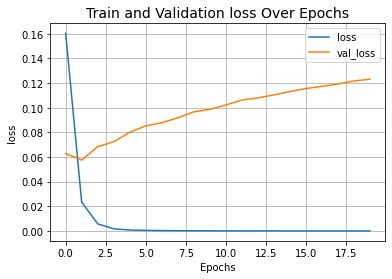

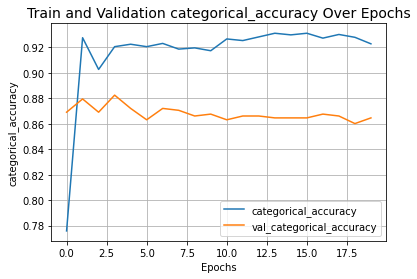

In [103]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [104]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

6/6 [==============================] - 0s 12ms/step - loss: 0.1332 - categorical_accuracy: 0.8748
Categorical accuracy on the test set: 87.48%.


# Reference
- https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b
- https://link.springer.com/chapter/10.1007%2F978-3-642-40846-5_16
- Descriptions for algorithms, process, and evaluation metrics: https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
- Algorithms: https://scikit-learn.org/stable/modules/multiclass.html
- Classifier chain: https://arxiv.org/abs/1912.13405, https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf
- Multilabel: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
- Keras: https://keras.io/examples/nlp/multi_label_classification/